In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy

In [2]:
print(np.__version__, pd.__version__, sns.__version__, scipy.__version__)

1.18.1 1.0.1 0.10.0 1.4.1


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('data/sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1121,00005845_002.png,No Finding,2,5845,031Y,F,PA,2500,2048,0.171,0.171
3093,00015229_000.png,Atelectasis,0,15229,061Y,M,PA,2854,2991,0.143,0.143
1748,00009231_008.png,Pneumothorax,8,9231,025Y,M,AP,2500,2048,0.168,0.168


# EDA

In [4]:
pd.set_option('display.max_columns', None)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


##### Transform 'Finding Labels' to one additional column per disease.  Assign 0 or 1 for presence of disease.

In [5]:
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN,0.103095,0.024759,0.041625,0.020540,0.118775,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN,0.304084,0.155391,0.199732,0.141841,0.323524,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

In [8]:
all_xray_df[all_xray_df['Patient Age']<100].describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN,0.103101,0.024763,0.041631,0.020535,0.118783,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN,0.304092,0.155402,0.199745,0.141820,0.323534,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
all_xray_df[all_xray_df['Patient Age']>100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Explore Demographics

Text(0.5, 0, 'Patient Age')

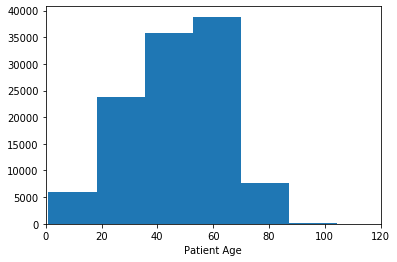

In [12]:
#Age distribution
plt.hist(all_xray_df['Patient Age'],bins=24)
plt.xlim(0,120)
plt.xlabel('Patient Age')

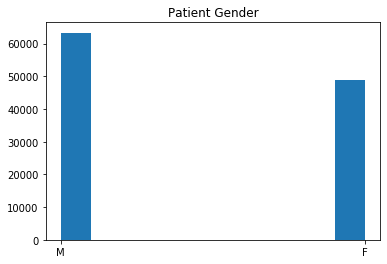

Number of Men in Data Set is M    63340
Name: Patient Gender, dtype: int64
Number of Women in Data Set is F    48780
Name: Patient Gender, dtype: int64


In [13]:
#Gender distribution
plt.hist(all_xray_df['Patient Gender'])
plt.title('Patient Gender')
plt.show()
print('Number of Men in Data Set is {}'.format(all_xray_df['Patient Gender'][(all_xray_df['Patient Gender']=='M')].value_counts()))
print('Number of Women in Data Set is {}'.format(all_xray_df['Patient Gender'][(all_xray_df['Patient Gender']=='F')].value_counts()))

#### Ratio of Males to Female is 63:49 or 56.5% Male, 43.5% Female in this dataset.  This ratio should be similar in training and validation data sets.

In [14]:
#Count how many unique patients
unique=all_xray_df['Patient ID'][all_xray_df['Follow-up #']==0].unique().shape[0]
print('Number of unique patients: ' + str(unique))

Number of unique patients: 30805


In [15]:
#Look at how many patients are have follow ups after first image.
repeats = all_xray_df['Patient ID'][all_xray_df['Follow-up #']>0].unique().shape[0]
print('Number of follow up patients: ' + str(repeats))

Number of follow up patients: 13302


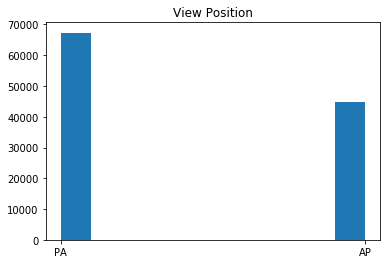

Number of XRays in PA position: PA    67310
Name: View Position, dtype: int64
Number of XRays in AP position: AP    44810
Name: View Position, dtype: int64


In [16]:
#Patient Position
plt.hist(all_xray_df['View Position'])
plt.title('View Position')
plt.show()
PA=all_xray_df['View Position'][all_xray_df['View Position']=='PA']
AP=all_xray_df['View Position'][all_xray_df['View Position']=='AP']

print('Number of XRays in PA position: ' + str(PA.value_counts()))
print('Number of XRays in AP position: ' + str(AP.value_counts()))

#### Ratio of XRays in PA position to those in AP position is 67:45, or 60% PA and 40% AP position.  When creating training and validation data sets, this ratio should be similar.

In [17]:
#Number of Pneumonia cases and Non-Pneumonia Cases
PosPneu=all_xray_df[all_xray_df['Pneumonia']==1]
NegPneu=all_xray_df[all_xray_df['Pneumonia']==0]
print('Total Pneumonia cases: '+ str(len(PosPneu)))
print('Total Non-Pneumonia cases: {}'.format(len(NegPneu)))
print('In this dataset, the percentage of pneumonia cases is {}%'.format(np.round(100*len(PosPneu)/(len(PosPneu)+len(NegPneu)), 2)))

Total Pneumonia cases: 1431
Total Non-Pneumonia cases: 110689
In this dataset, the percentage of pneumonia cases is 1.28%


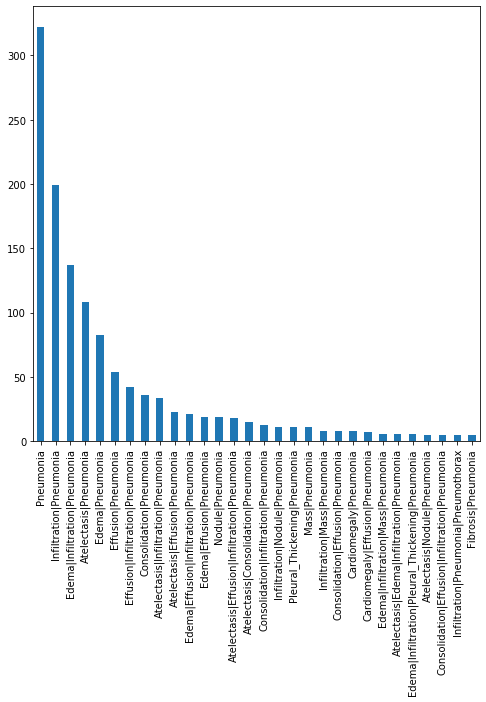

In [19]:
#Comorbitiy with other diseases
plt.figure(figsize=(8,8))
PosPneu['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [18]:
print('Top 10 Co-morbid with pneumonia: \n{}'.format(PosPneu['Finding Labels'].value_counts()[0:10]))

Top 10 Co-morbid with pneumonia: 
Pneumonia                             322
Infiltration|Pneumonia                199
Edema|Infiltration|Pneumonia          137
Atelectasis|Pneumonia                 108
Edema|Pneumonia                        83
Effusion|Pneumonia                     54
Effusion|Infiltration|Pneumonia        42
Consolidation|Pneumonia                36
Atelectasis|Infiltration|Pneumonia     34
Atelectasis|Effusion|Pneumonia         23
Name: Finding Labels, dtype: int64


In [20]:
#Number of Disease per patient with Mean
all_xray_df['Total Disease Count']=all_xray_df[all_labels].sum(axis=1)
all_xray_df['Total Disease Count'][all_xray_df['No Finding']==1.0] = 0
print('Average Number of Diseases per person: {}'.format(np.round(all_xray_df['Total Disease Count'].mean(),2)))


Average Number of Diseases per person: 0.72


H:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Total Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


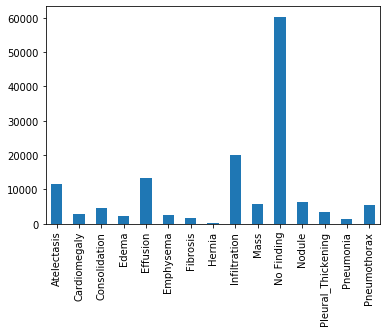

In [22]:
all_xray_df[all_labels].sum().plot(kind='bar')

In [23]:
(all_xray_df['No Finding']==0).sum()

51759

(0, 120)

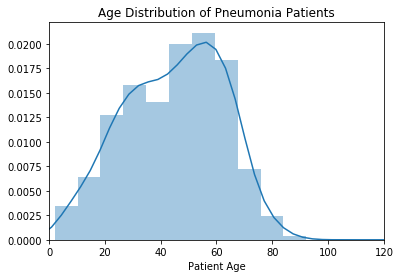

In [24]:
#Age Distribution of Pneumonia Patients
sns.distplot(PosPneu['Patient Age'])
plt.title('Age Distribution of Pneumonia Patients')
plt.xlim(0,120)

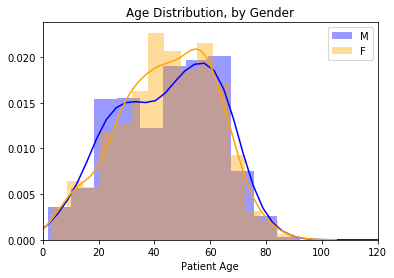

In [25]:
#Age Distribution of Pneumonia Patients, Separated by Gender
sns.distplot(PosPneu['Patient Age'][PosPneu['Patient Gender']=='M'],color='blue', label='M')
sns.distplot(PosPneu['Patient Age'][PosPneu['Patient Gender']=='F'],color='orange', label='F')
plt.title('Age Distribution, by Gender')
plt.xlim(0,120)
plt.legend()
plt.savefig('out/Age_Distribution')

In [29]:
scipy.stats.ttest_ind(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=='M'],
                      all_xray_df['Patient Age'][all_xray_df['Patient Gender']=='F'],nan_policy='omit')

Ttest_indResult(statistic=6.638869323824814, pvalue=3.1753206576524107e-11)

#### T-test reveals that the age ditributions of Pneumonia patients statistically differ between Male and Female.  
#### Males appear bi-modal, wheareas Females look like a normal distribution.
#### When preparing the training and validation datasets, I must ensure that the Age distribution separated by gender in each set are statisically the same as the overall dataset by using a T-Test comparison.

# Pixel Level Assessments

In [30]:
#sample_df will be used for this EDA
samp_labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
samp_labels=[x for x in samp_labels if len(x)>0]
print(samp_labels)

for label in samp_labels:
    if len(label)>1:
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
sample_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Find image paths for png listed.  Code from Model section
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head()

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,data\images\images_001\images\00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000032_001.png


Text(0.5, 1, 'No Finding AP Position')

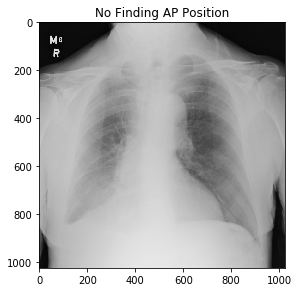

In [39]:
#AP Position
sampimg1=imread('data/images/images_001/images/00000017_001.png')
imshow(sampimg1, cmap='gray')
plt.title('No Finding AP Position')

Text(0.5, 1, 'Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')

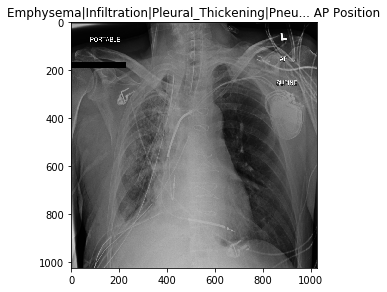

In [41]:
sampimg2=imread('data/images/images_001/images/00000013_005.png')
imshow(sampimg2, cmap='gray')
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')

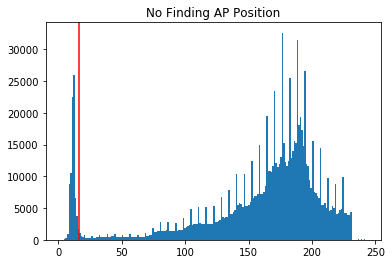

In [42]:
plt.hist(sampimg1.ravel(),bins=200)
plt.title('No Finding AP Position')
plt.axvline(16,color='red')
plt.show()



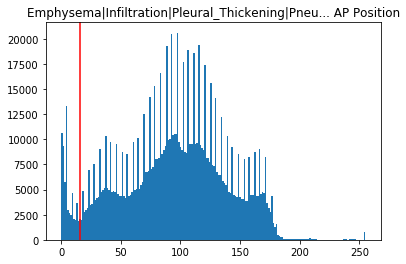

In [43]:
plt.hist(sampimg2.ravel(),bins=200)
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')
plt.axvline(16,color='red')
plt.show()

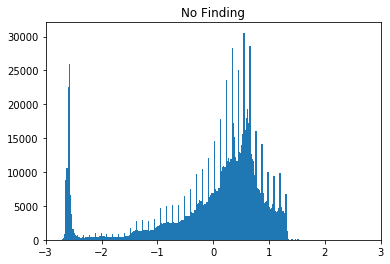

In [44]:
#Normalize Image Data
normimg1=(sampimg1-sampimg1.mean())/sampimg1.std()
plt.hist(normimg1.ravel(), bins=200)
plt.xlim(-3,3)
plt.title('No Finding')
plt.show()

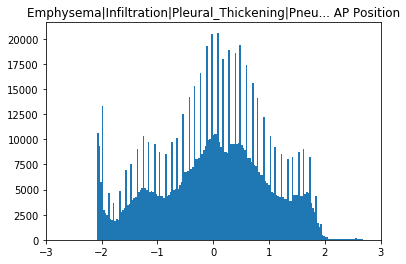

In [45]:
normimg2=(sampimg2-sampimg2.mean())/sampimg2.std()
plt.hist(normimg2.ravel(), bins=200)
plt.xlim(-3,3)
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')
plt.show()

Posterior-Anterior (PA) is the standard projection
PA projection is not always possible
Anterior-Posterior (AP) projection: Sometimes it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand.  AP projection is taken with patient sitting.
Both PA and AP views are viewed as if looking at the patient from the front

PA views are of higher quality and more accurately assess heart size than AP images
  
    https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection

# PA Position 

In [46]:
#PA Position
sample_dfPA=sample_df[sample_df['View Position']=='PA']

In [47]:
sample_dfPA[sample_dfPA['Pneumonia']==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143000,0.143000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images\images_002\images\00001529_004.png
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168000,0.168000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images\images_002\images\00001993_000.png
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171000,0.171000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,data\images\images_003\images\00004074_000.png
776,00004075_000.png,Atelectasis|Pneumonia,0,4075,032Y,F,PA,2048,2500,0.171000,0.171000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images\images_003\images\00004075_000.png
1305,00006843_000.png,Atelectasis|Pneumonia,0,6843,005Y,F,PA,2048,2500,0.171000,0.171000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images\images_004\images\00006843_000.png
1573,00008154_000.png,Atelectasis|Consolidation|Mass|Pneumonia,0,8154,053Y,F,PA,2048,2500,0.168000,0.168000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,data\images\images_004\images\00008154_000.png
1683,00008763_001.png,Nodule|Pneumonia,1,8763,061Y,M,PA,2500,2048,0.168000,0.168000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images\images_004\images\00008763_001.png
2035,00010552_005.png,Infiltration|Pneumonia,5,10552,039Y,M,PA,2622,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images\images_005\images\00010552_005.png
2148,00011104_004.png,Infiltration|Nodule|Pneumonia,4,11104,060Y,M,PA,2992,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images\images_005\images\00011104_004.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images\images_006\images\00012158_025.png


Text(0.5, 1, 'Pneumonia PA Position')

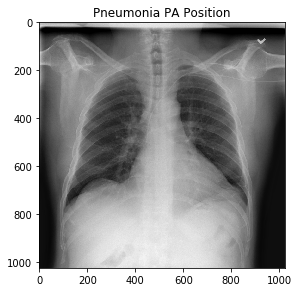

In [48]:
sampimgPA1=imread('data/images/images_009/images/00019021_001.png')
imshow(sampimgPA1, cmap='gray')
plt.title('Pneumonia PA Position')

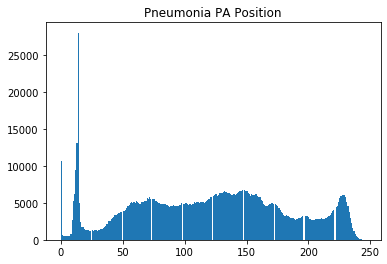

In [49]:
plt.hist(sampimgPA1.ravel(),bins=256)
plt.title('Pneumonia PA')
plt.title('Pneumonia PA Position')
plt.show()

In [50]:
normimgPA1 = (sampimgPA1-sampimgPA1.mean())/sampimgPA1.std()

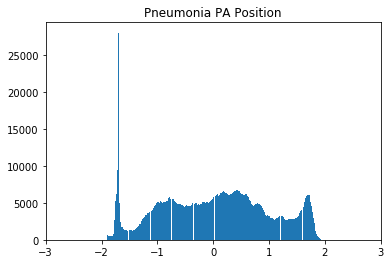

In [51]:
plt.hist(normimgPA1.ravel(),bins=256)
plt.xlim(-3,3)
plt.title('Pneumonia PA Position')
plt.show()

In [52]:
sample_dfPA[sample_dfPA['No Finding']==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000080_005.png
13,00000083_000.png,No Finding,0,83,056Y,F,PA,2048,2500,0.171000,0.171000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000083_000.png
28,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000165_008.png
34,00000188_001.png,No Finding,1,188,045Y,M,PA,2698,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000188_001.png
35,00000194_004.png,No Finding,4,194,084Y,F,PA,2614,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_001\images\00000194_004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,00030636_017.png,No Finding,17,30636,046Y,M,PA,2021,2021,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_012\images\00030636_017.png
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_012\images\00030704_000.png
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_012\images\00030712_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images\images_012\images\00030792_000.png


Text(0.5, 1, 'No Finding PA Position')

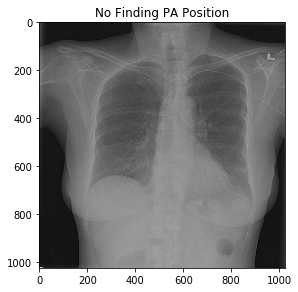

In [53]:
sampimgPA2=imread('data/images/images_001/images/00000080_005.png')
imshow(sampimgPA2)
plt.title('No Finding PA Position')

In [54]:
normimgPA2= (sampimgPA2-sampimgPA2.mean())/sampimgPA2.std()

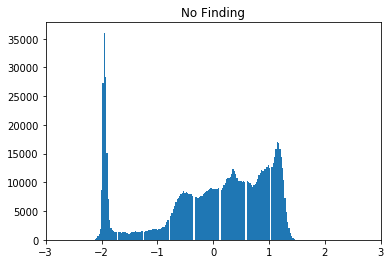

In [55]:
plt.hist(normimgPA2.ravel(),bins=256)
plt.title('No Finding')
plt.xlim(xmin=-3,xmax=3)
plt.show()

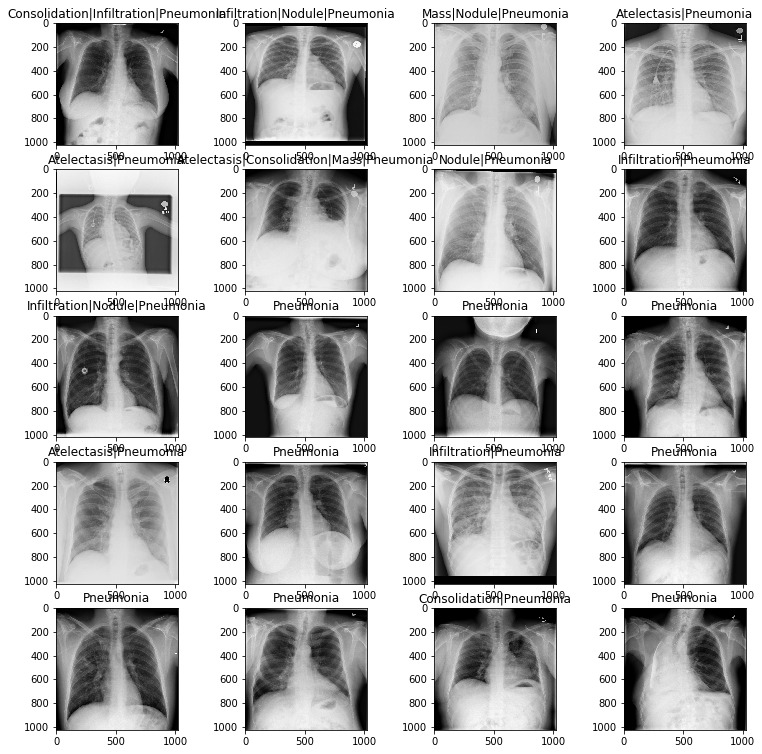

In [56]:
#PA Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=imread(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['path'])
    n_axis[x].imshow(img,cmap="gray")
    n_axis[x].set_title(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['Finding Labels'])

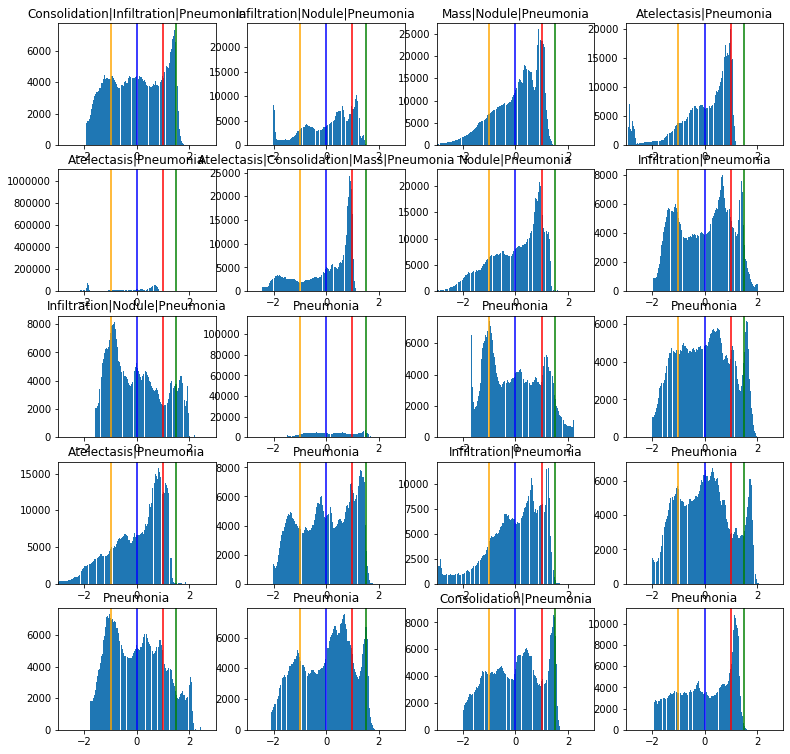

In [57]:
#PA Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=imread(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['path'])
    img= img[img>16]
    
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(), bins=256)
    n_axis[x].set_title(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')
    

***Looking at normalized distributions for Pneumonia images, there is high intensities at approximately 1.5sigma, 1sigma, between 0-0.5 sigma, and -1sigma. The upper range for Number of pixels axis can be from 6,000 - 25,000.
<br>Intensity profiles for only Pneumonia shows the Number of pixels axis has a narrower upper range of 6,000 - 10,000.
approximately 1.5sigma, between 0-0.5 sigma, and -1sigma.
<br>Intensity profiles for Pneumonia with Atelectasis have spikes at 1sigma that are over 15,000 pixel counts.***

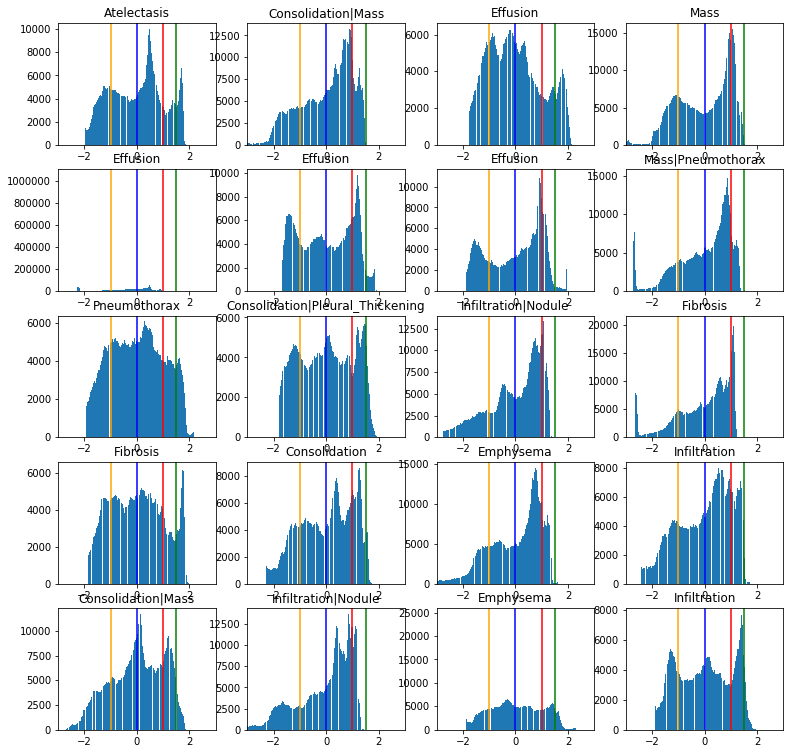

In [58]:
#PA Position with NO Pneumonia, but other Disease
other_no_pneu=sample_dfPA[(sample_dfPA['Pneumonia']==0.0) & (sample_dfPA['No Finding']==0)]

fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(other_no_pneu.iloc[x]['path'])
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(),bins=256)
    n_axis[x].set_title(other_no_pneu.iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

***Infiltration distributions can look similar to Pneumonia with spikes at approximately 1.5sigma, between 0-0.5 sigma, and -1sigma.  Looking at the frequency of Infiltration in this dataset, there are more instances of Infiltration than Pneumonia.
Hopefully the model can distinguish Infiltration with no Pneumonia from Infiltration with Pneumonia, through learning from Infiltration images that do not have Pneumonia.***

***On the other hand, Atelectasis without Pneumonia looks distinctly different from Atelectasis with Pneumonia.  This is very good, so that Atelectasis will not be likely Falsely Labeled as Pneumonia.***

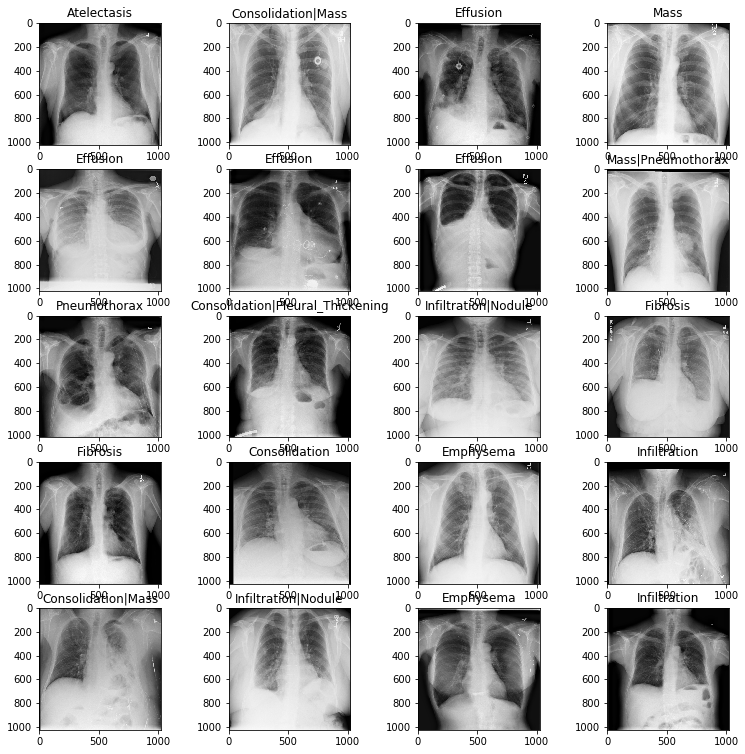

In [59]:
#Histogram: PA Position with NO Pneumonia, but other Disease 
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(other_no_pneu.iloc[x]['path'])
    n_axis[x].imshow(img, cmap="gray")
    n_axis[x].set_title(other_no_pneu.iloc[x]['Finding Labels'])

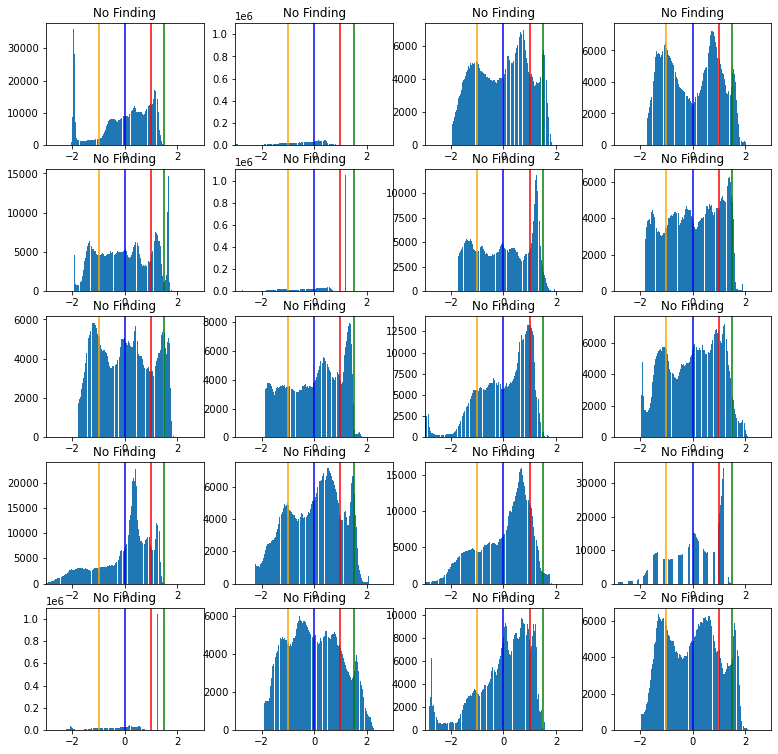

In [61]:
#PA Position No Findings
no_finding=sample_dfPA[sample_dfPA['No Finding']==1]

fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(no_finding.iloc[x]['path'])
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg, bins=256)
    n_axis[x].set_title(no_finding.iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

#### There appear to be some No Finding distributions that may have spikes at 1.5sigma, between 0-0.5 sigma, and -1sigma. Hopefully, the algorithm may find more nuances in the complete distribution shape.

# AP Position

In [60]:
#AP Position
sample_dfAP=sample_df[sample_df['View Position']=='AP']

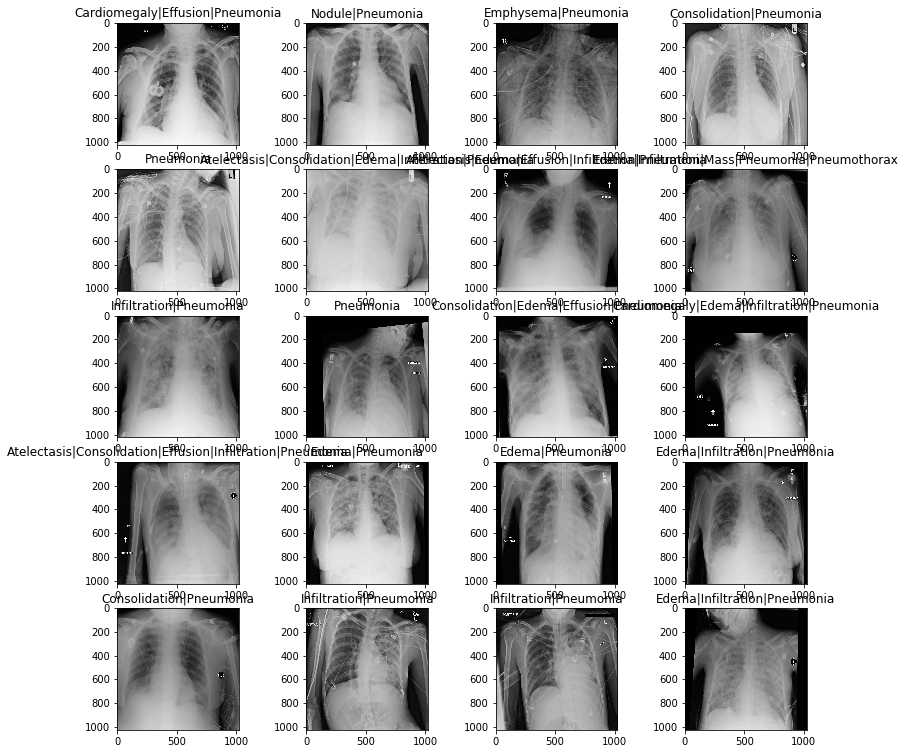

In [61]:
#AP Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=imread(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['path'])
    n_axis[x].imshow(img,cmap="gray")
    n_axis[x].set_title(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['Finding Labels'])

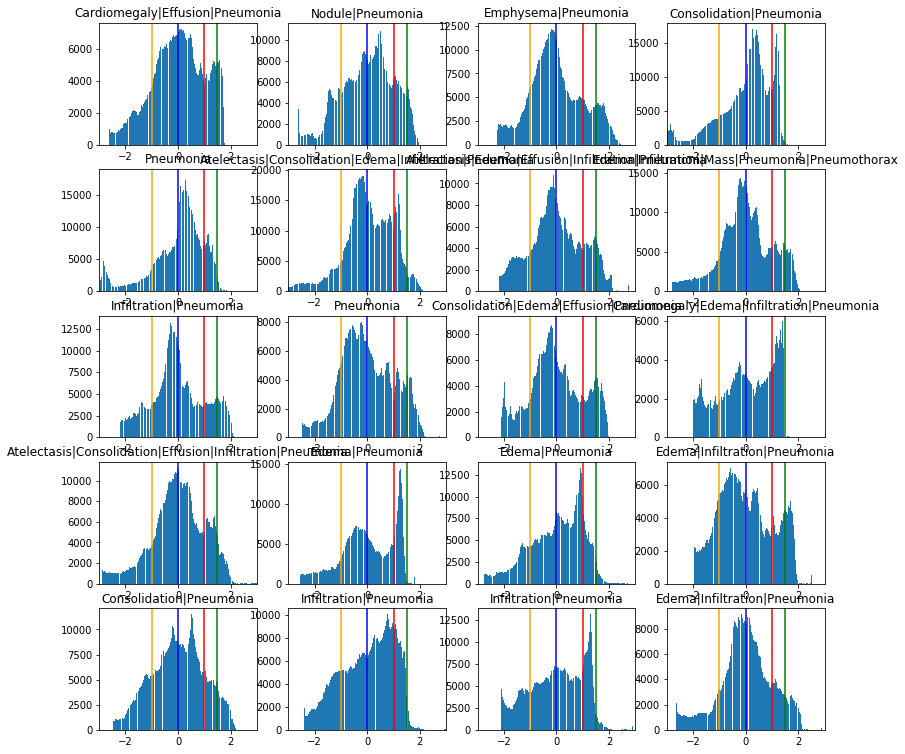

In [62]:
#AP Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=imread(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['path'])
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(), bins=256)
    n_axis[x].set_title(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

***The AP Position Intensity profiles appear different than PA position distributions.  For Positive Pneumonia labels, there is high intensities at approximately 0sigma and 1.5 sigma. The upper range for Number of pixels axis can be from 6,000 - 20,000.
<br>Intensity profiles for only Pneumonia shows the Number of pixels axis has a narrower upper range of 6,000 - 15,000.  Intensity spike is at approximately 0sigma.***

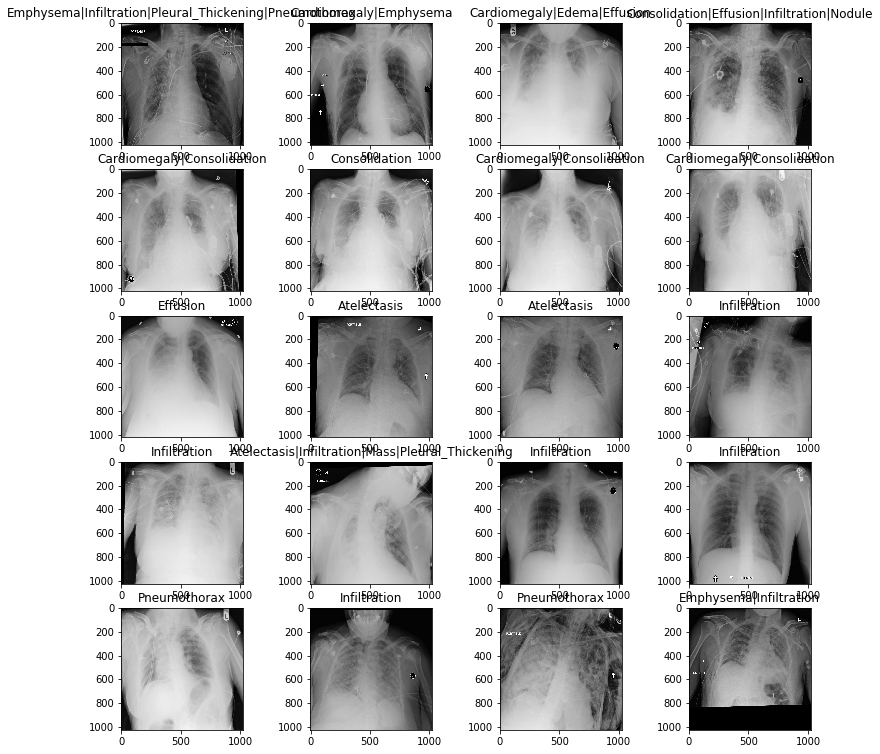

In [63]:
#Histogram: AP Position with NO Pneumonia, but other Disease 
other_no_pneu_AP=sample_dfAP[(sample_dfAP['Pneumonia']==0.0) & (sample_dfAP['No Finding']==0)]

fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(other_no_pneu_AP.iloc[x]['path'])
    n_axis[x].imshow(img, cmap="gray")
    n_axis[x].set_title(other_no_pneu_AP.iloc[x]['Finding Labels'])

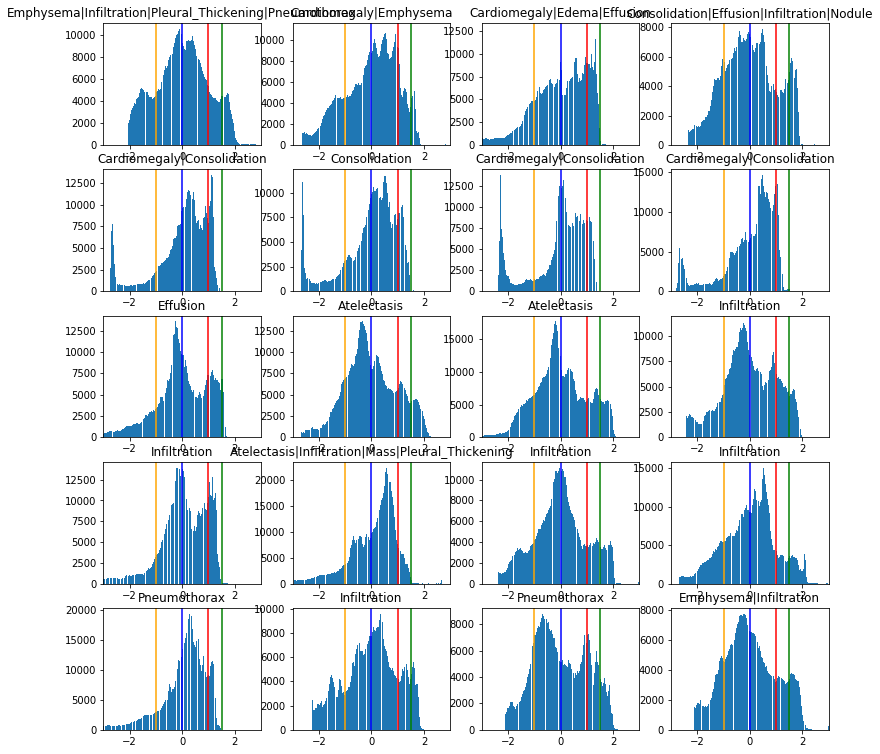

In [64]:
#AP Position with NO Pneumonia, but other Disease

fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(other_no_pneu_AP.iloc[x]['path'])    
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(),bins=256)
    n_axis[x].set_title(other_no_pneu_AP.iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

***Compared to the PA distributions, the AP distributions have intensity spikes at 0sigma.  
Similar to the PA distributions, AP distribution profiles for Infiltration with no Pneumonia appear similar to Infiltration with Pneumonia.  
The presence of Infiltration may confound detection of Pneumonia.***

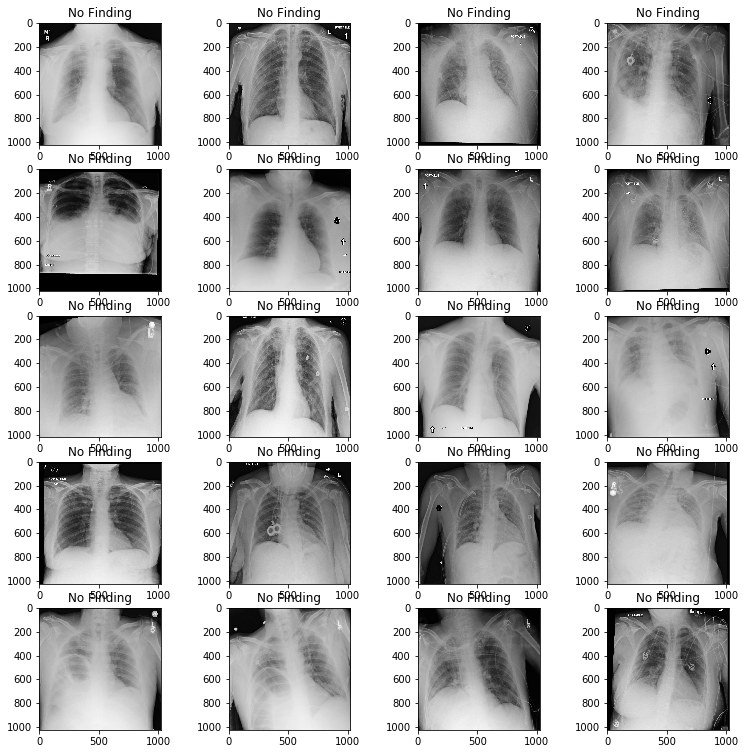

In [65]:
#AP Position No Findings
no_finding_AP=sample_dfAP[sample_dfAP['No Finding']==1]

fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(no_finding_AP.iloc[x]['path'])
    n_axis[x].imshow(img,cmap="gray")
    n_axis[x].set_title(no_finding_AP.iloc[x]['Finding Labels'])

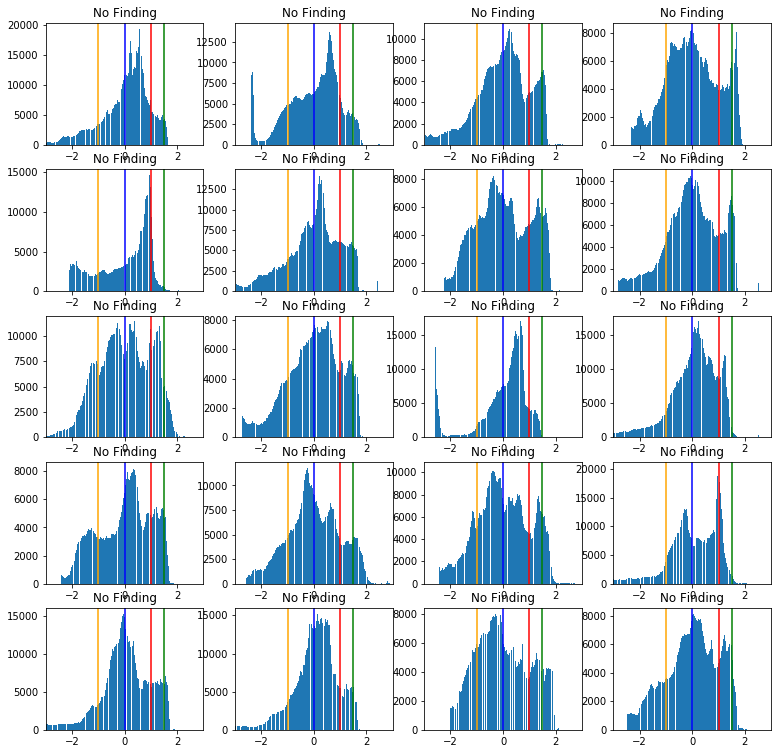

In [66]:
#AP Position No Findings Histogram
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()


for x in range(20):
    img=imread(no_finding_AP.iloc[x]['path'])
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg, bins=256)
    n_axis[x].set_title(no_finding_AP.iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

#### There appear to be some No Finding distributions that may have spikes at 0sigma, and 1.5sigma. Hopefully, the algorithm may find more nuances in the complete distribution shape.

# Unused Code

In [67]:
'''Intensity Profiles:
1.  Sample_df split into 2: Positive Pneumonia (samp_pos_1) and Negative Pneumonia (samp_neg_1) cases.
2.  Sample_df split into 4: PA Position Positive Pneumonia(samp_PA_pos), PA Position Negative Pneumonia (samp_PA_neg), 
                            AP Position Positive Pnemonia (samp_AP_pos), and AP Position Negative Pneumonia (samp_AP_neg) cases
Determine if there is a difference between PA and AP for positive and negative profiles.
'''

samp_pos_1 = []

for x in range(len(sample_df[sample_df['Pneumonia']==1.0])):
    img=imread(sample_df[sample_df['Pneumonia']==1.0].iloc[x]['path'])
    samp_pos_1.extend(img[img>15].flatten().tolist())

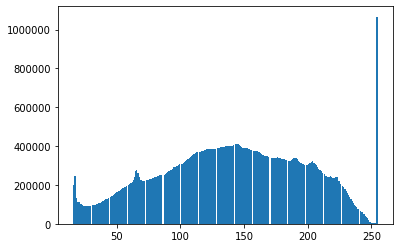

In [68]:
plt.hist(samp_pos_1,bins=256)
plt.show()

In [ ]:
samp_neg_1 = []

for x in range(len(sample_df[sample_df['Pneumonia']==0])):
    img=imread(sample_df[sample_df['Pneumonia']==0].iloc[x]['path'])
    samp_neg_1.extend(img[img>16].flatten().tolist())

In [ ]:
plt.hist(samp_neg_1,bins=256)

In [ ]:
samp_PA_pos=[]
samp_AP_pos=[]
samp_AP_neg=[]

for x in range(len(sample_df[(sample_df['Pneumonia']==1.0)& (sample_df['View Position']='PA')])):
    img=imread(sample_df[sample_df['Pneumonia']==1.0 & (sample_df['View Position']='PA')].iloc[x]['path'])
    samp_PA_pos.extend(img.flatten().tolist())

    samp_PA_neg=[]
for x in range(len(sample_df[(sample_df['Pneumonia']==0)& (sample_df['View Position']='PA')])):
    img=imread(sample_df[sample_df['Pneumonia']==0 & (sample_df['View Position']='PA')].iloc[x]['path'])
    samp_PA_neg.extend(img.flatten().tolist())

for x in range(len(sample_df[(sample_df['Pneumonia']==1.0)& (sample_df['View Position']='AP')])):
    img=imread(sample_df[sample_df['Pneumonia']==1.0 & (sample_df['View Position']='AP')].iloc[x]['path'])
    samp_AP_pos.extend(img.flatten().tolist())
    
for x in range(len(sample_df[(sample_df['Pneumonia']==0)& (sample_df['View Position']='AP')])):
    img=imread(sample_df[sample_df['Pneumonia']==0 & (sample_df['View Position']='AP')].iloc[x]['path'])
    samp_AP_neg.extend(img.flatten().tolist())